In [1]:
"""Jupyter Notebook for relaxation time analysis"""
#The main analysis parts adapted from script by  H. Antila, with help from S. Ollila and T. Ferreira
#saved in relaxation_times.py
# Last modified by R. Nencini, 19.10.2021

import sys
import numpy as np
from scipy import optimize
import relaxation_times as rt
import matplotlib.pyplot as plt
import os
#from numba import jit #

#gyromagnetic ratios for further developmant
# !!! NOTICE!!!
#values taken from matlab code and projecct work and slightly different than those in Wikipedia
#these values are also in the external file --> if change is needed; has to be changed there
#values here in jupyter just for the information and verify, why they are different
#!!! NOTICE END !!!
gammaD=41.695*10**6; #r*s^(-1)*T^(-1)
gammaH=267.513*10**6;
gammaC=67.262*10**6;
gammaN=-27.166*10**6;

/home/local/nenciric/Documents/git/NMR_FF_tools/relaxation_times/relaxation_times.py:58: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if line is "":


In [39]:
"""Parameters to be specified by the user"""
OP=0 # order parameter
smallest_corr_time=0 # enter in log scale -3 fs; 0 ps; 3 ns; 6 us;
biggest_corr_time=4 # same as above
N_exp_to_fit=100 # number of exponential functions to be fitted between the samlles and biggest corr time
analyze=1/10 # the proportin of correlation data to be used for fitting, ex. 1/2 uses first half of the data
magnetic_field=2.35 # 5.99 # 8.49 T (values used in SDS paper, J.Chem. Soc.,, Faraday Trans. 1, 1988, 84(12), 4475-4486)
nuclei="2H" #nuclei to calculate: 2H-deutherium; 13C - carbon; 15N - nitrogen 

##############3
## CHANGE IN THE CODE 6.4.2022, not going throught the whole content of the folder anymore
###############
take_all_in_folder="yes" #"yes"/"no"/"number" analyze all in folder? useful for proteins, if no, fill the following line, if yes fill the folder path
input_corr_file="alphaCF.xvg"
residues=24 # number of AA in a peptine, for take_all_in_folder="number"
input_prefix="" # mostly for peptides, works with take_all_in_folder="no"
folder_path="/home/nenciric/Documents/git/CorysPeptides/figure1/water_correlation_functions/OPC/"
output_name="SDS_micelle"
author_name="Ricky Nencini"

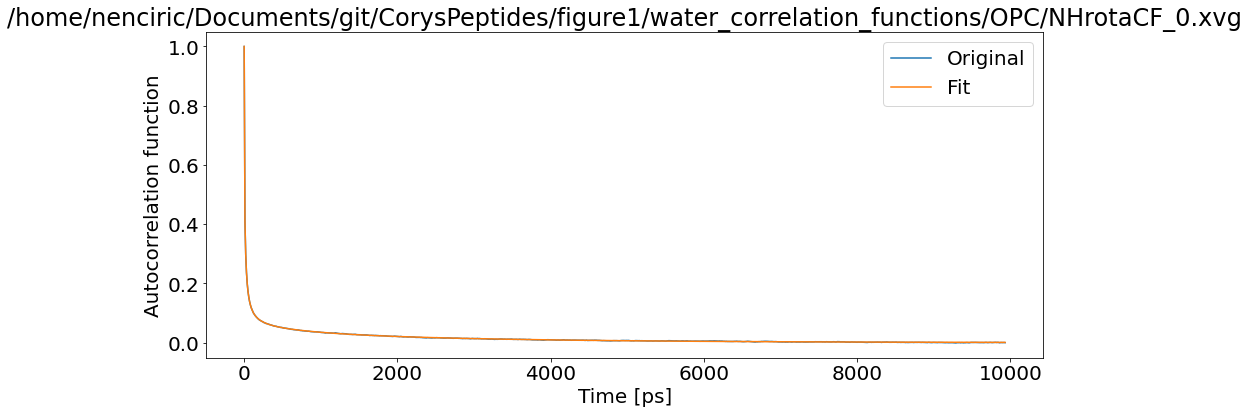

R1: 54.24332745767088 R2: 59.857661345965475 NOE: 0


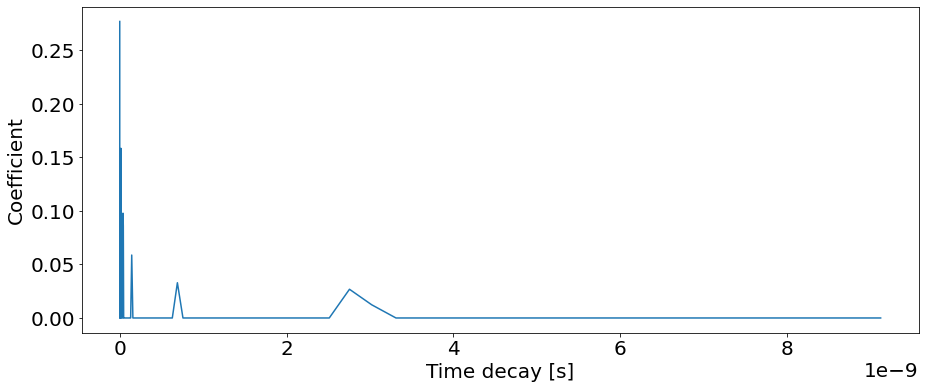

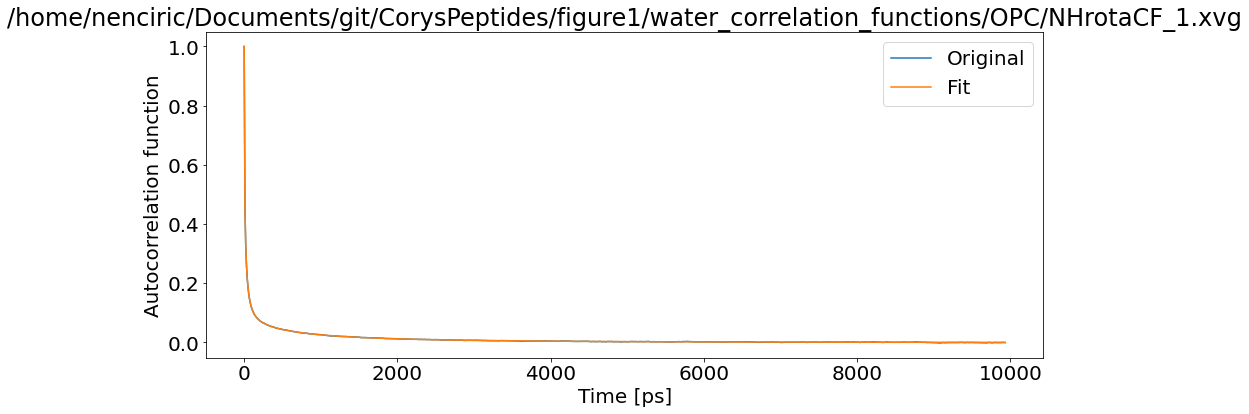

R1: 41.67521824956845 R2: 43.84104154975164 NOE: 0


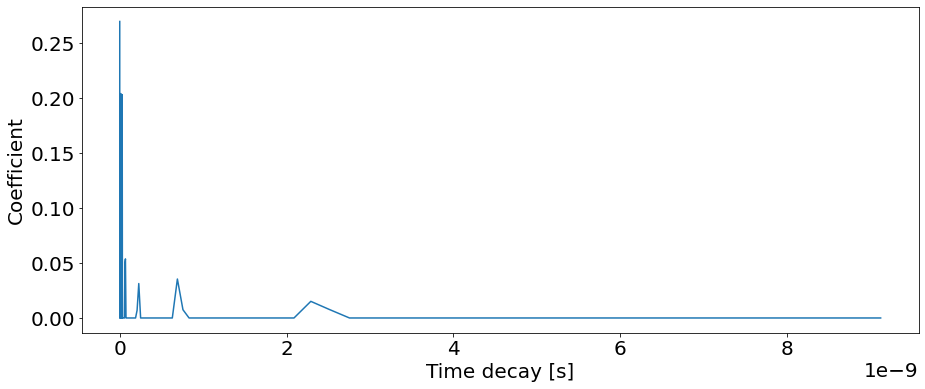

In [40]:
"""Execute the code - this part needs not be modified"""
#rt.initilize_output(OP,smallest_corr_time, biggest_corr_time, N_exp_to_fit,analyze,magnetic_field,input_corr_file,nuclei,output_name,author_name)
step_exp=(biggest_corr_time-smallest_corr_time)/N_exp_to_fit
Ctimes = 10 ** np.arange(smallest_corr_time, biggest_corr_time, step_exp)
Ctimes = Ctimes * 0.001 * 10 ** (-9);
if take_all_in_folder=="yes":
    Ctimes_list=[Ctimes* 10 ** (12)]
    for file in os.listdir(folder_path):
        input_corr_file = folder_path+os.fsdecode(file)
        AA=rt.GetRelaxationData(OP,smallest_corr_time, biggest_corr_time, N_exp_to_fit,analyze,magnetic_field,input_corr_file,nuclei,output_name)
        Ctimes_list.append(AA.Coeffs)
    Ctimes_to_save=np.array(Ctimes_list)
    Ctimes_to_save=np.transpose(Ctimes_to_save)
    np.savetxt("/home/nenciric/Documents/git/CorysPeptides/figure1/"+output_name+"_OPC_coeff.out",Ctimes_to_save)
    
elif take_all_in_folder=="number":
    Ctimes_to_save=np.zeros([len(Ctimes),residues])
    Ctimes_to_save[:,0]=Ctimes
    for i in range(0,residues+1):
        input_corr_file = folder_path+input_prefix+str(i)+".xvg"
        AA=rt.GetRelaxationData(OP,smallest_corr_time, biggest_corr_time, N_exp_to_fit,analyze,magnetic_field,input_corr_file,nuclei,output_name)
        Ctimes_to_save[:,1]=AA.Coeffs
else:
    AA=rt.GetRelaxationData(OP,smallest_corr_time, biggest_corr_time, N_exp_to_fit,analyze,magnetic_field,input_corr_file,nuclei,output_name)

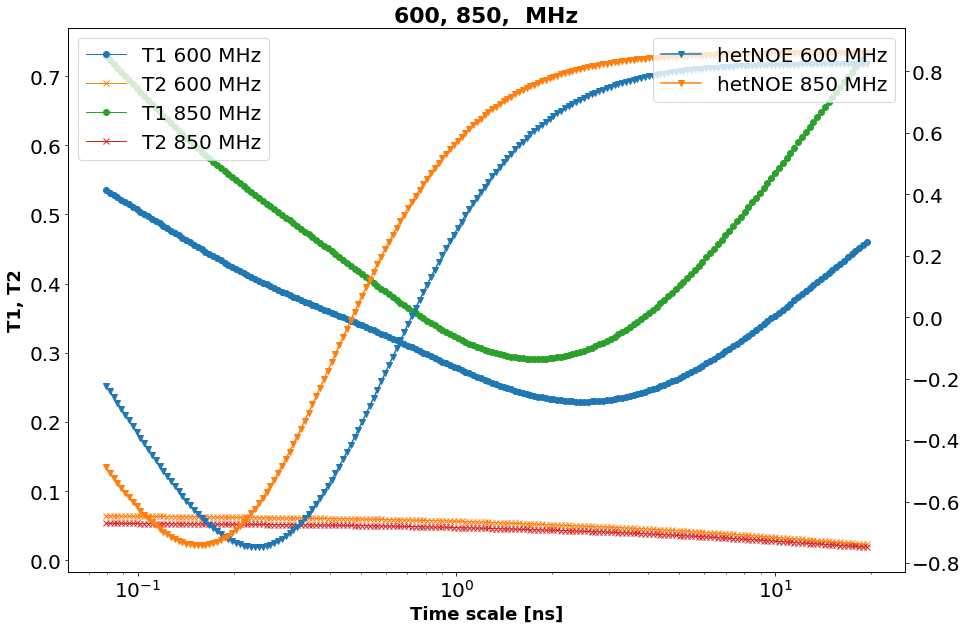

In [260]:
#plot relaxation times as a function of dynamics and magnetic field, only 2D plot, atm
magnetic_fields=[600,850]


smallest_corr_time=1.9 # enter in log scale -3 fs; 0 ps; 3 ns; 6 us;
biggest_corr_time=4.3 # same as above
N_exp_to_fit=200 # number of exponential functions to be fitted between the samlles and biggest corr time

step_exp=(biggest_corr_time-smallest_corr_time)/N_exp_to_fit
Ctimes = 10 ** np.arange(smallest_corr_time, biggest_corr_time, step_exp)
Ctimes = Ctimes * 0.001 * 10 ** (-9);

fig,ax = plt.subplots(figsize=(15, 10))
ax.set_xlabel("Time scale [ns]",fontsize=18, weight = 'bold')
ax.set_ylabel("T1, T2",fontsize=18, weight = 'bold')
ax.set_xscale('log')
ax2.set_ylabel("hetNOE",fontsize=18, weight = 'bold')
ax2.set_xscale('log')
ax2=ax.twinx()

title=""
for magn_field in magnetic_fields:
    magnetic_field=magn_field*2*np.pi/gammaH*10**6
    
    T1=[]
    T2=[]
    NOE=[]
    for time_scale in Ctimes:
        t1, t2, noe = rt.get_relaxation_N(magnetic_field,[1,1],[time_scale,10**-8],OP)
        T1.append(t1)
        T2.append(t2)
        NOE.append(noe)
        
    
    ax.plot(Ctimes*10**9,T1,label="T1 " + str(magn_field)+ " MHz",  marker="o", linewidth=1.0)
    ax.plot(Ctimes*10**9,T2,label="T2 " + str(magn_field)+ " MHz",   marker="x", linewidth=1.0)
    
    
    ax2.plot(Ctimes*10**9,NOE,label="hetNOE " + str(magn_field)+ " MHz",marker="v")
    title+= str(magn_field) + ", "
    

ax.set_title(str(title)+ " MHz",fontsize=22, weight = 'bold')
ax2.legend(loc='upper right')

ax.legend(loc='upper left')
plt.show()